In [23]:
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import csv
import skimage
from skimage.io import imread
import rasterio
import pandas
import json
from tqdm import tqdm
%matplotlib inline

In [24]:
# Processes an xView GeoJSON file
# INPUT: filepath to the GeoJSON file
# OUTPUT: Bounding box coordinate array, Chip-name array, and Class-id array
def get_labels_w_uid(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    x_buffer = 15
    y_buffer = 15
    right_shift = 5 # how much shift to the right 
    offset_vector = np.array([-x_buffer + right_shift, y_buffer, x_buffer + right_shift, -y_buffer])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)
    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    uids = np.zeros((len(data['features'])))
    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try:
                b_id = data['features'][i]['properties']['Joined lay']
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['type']
                uids[i] = int(data['features'][i]['properties']['uniqueid'])
            except:
                  pass
            if val.shape[0] != 4:
                print("Messed up: %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'

    coords = np.add(coords, offset_vector)

    return coords, chips, classes, uids

In [25]:
coords, chips, classes, uids = get_labels_w_uid('../dssg_data/harvey_ms_2class_fixedprecision.geojson')

100%|██████████| 126937/126937 [00:00<00:00, 149928.98it/s]


In [26]:
print(coords[1000], chips[1000], classes[1000], uids[1000])

[ 314. 1155.  380. 1092.] 20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif 2.0 1025.0


In [27]:
import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance



In [28]:
def draw_bboxes_withindex(img, boxes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 15)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        idx +=1
    print(b)
    return source



/home/ubuntu/dssg/dssg_data/image_tiles_aws/20170831_105001000B95E100_2131131_jpeg_compressed_02_09.tif
(3, 2048, 2048)
[ 565. 2082.  618. 2002.]


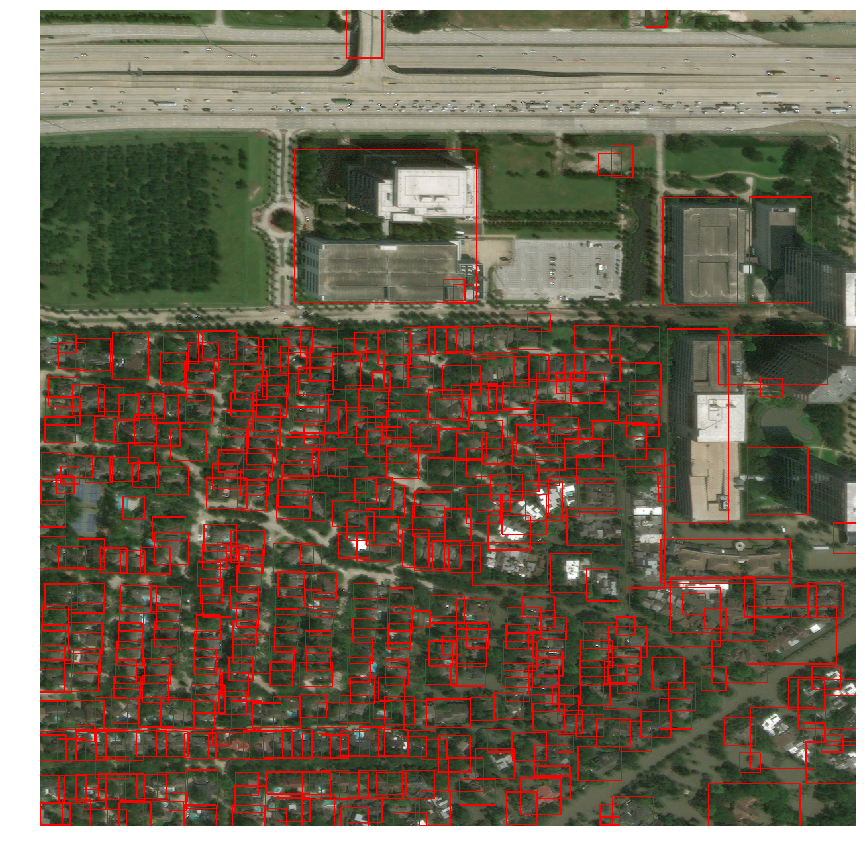

In [36]:
#Load an image
path = '/home/ubuntu/dssg/dssg_data/image_tiles_aws/'
chip_name = '20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif'
chip_name = '20170831_105001000B95E100_2131131_jpeg_compressed_02_09.tif'


chip_fullname = path + chip_name
print(chip_fullname)
with rasterio.open(chip_fullname, "r") as r:
    arr = r.read()
    print(arr.shape)
    arr = np.rollaxis(arr,0,3)
    coords_chip = coords[chips==chip_name]
    classes_chip = classes[chips==chip_name].astype(np.int64)
    uids_chip = uids[chips == chip_name].astype(np.int64)
    labelled = draw_bboxes_withindex(arr,coords_chip, uids_chip)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [30]:
import tensorflow as tf
tf.enable_eager_execution()

In [31]:
tfds = tf.data.TFRecordDataset(
    r'../dssg_data/harvey_test_t1_chipped.record',
    compression_type=None,
    buffer_size=None,
    num_parallel_reads=None,
)

In [32]:
def parse_fn(data_record):
    feature = {'image/encoded': tf.FixedLenFeature([], tf.string),
               'image/object/class/label': tf.FixedLenFeature([], tf.int64),
               'image/height': tf.FixedLenFeature([], tf.int64),
               'image/width': tf.FixedLenFeature([], tf.int64),
               'image/encoded': tf.FixedLenFeature([], tf.string),
               'image/format': tf.FixedLenFeature([], tf.string),
               'image/object/bbox/xmin': tf.VarLenFeature(tf.float32),
               'image/object/bbox/xmax': tf.VarLenFeature(tf.float32),
               'image/object/bbox/ymin': tf.VarLenFeature(tf.float32),
               'image/object/bbox/ymax': tf.VarLenFeature(tf.float32),
               'image/object/class/text': tf.VarLenFeature(tf.string),
               'image/object/class/label': tf.VarLenFeature(tf.int64)
                }
    sample = tf.parse_single_example(data_record, feature)
    return(sample)

In [33]:
# loop through examples and stack them in a list of dictionaries

d_list = []

for raw_record in tfds.take(2):
    example = tf.train.Example()
    try: 
        parsed_example = parse_fn(raw_record)
        encoded_image = parsed_example['image/encoded']
        decoded_image = tf.image.decode_jpeg(encoded_image, channels=3)
        d = {}
        d['image/decoded'] = decoded_image  
        d['image/object/class/label'] = parsed_example['image/object/class/label'].values.numpy()
        d['image/object/bbox/xmin'] = parsed_example['image/object/bbox/xmin'].values.numpy()
        d['image/object/bbox/xmax'] = parsed_example['image/object/bbox/xmax'].values.numpy()
        d['image/object/bbox/ymin'] = parsed_example['image/object/bbox/ymin'].values.numpy()
        d['image/object/bbox/ymax'] = parsed_example['image/object/bbox/ymax'].values.numpy()
        print(d)
    except Exception as e:
        print(e)
        print("error parsing")
        pass
    d_list.append(d)

{'image/decoded': <tf.Tensor: id=121, shape=(300, 300, 3), dtype=uint8, numpy=
array([[[240, 250, 249],
        [240, 250, 249],
        [240, 250, 249],
        ...,
        [201, 216, 211],
        [201, 216, 213],
        [201, 216, 213]],

       [[240, 250, 249],
        [240, 250, 249],
        [240, 250, 249],
        ...,
        [200, 215, 210],
        [200, 215, 212],
        [199, 214, 211]],

       [[240, 250, 249],
        [240, 250, 249],
        [240, 250, 249],
        ...,
        [200, 215, 210],
        [200, 215, 212],
        [200, 215, 212]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        